학번: 20183911

이름: 김수현


# 1. Convolutional Neural Networks
---
이번 실습에서는 **CNN**을 활용하여 CIFAR-10 dataset에 적용을 해보도록 하겠습니다.

CIFAR-10 dataset은 작은 크기의 color image들을 10개 class로 분류되어 있는 dataset입니다.
아래 그림이 dataset에 대한 예제입니다.

각 이미지는 3x32x32 크기의 image입니다.

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

이번 실습에서 GPU를 통해서 연산하고 Neural network 학습을 진행하겠습니다.
아래 셀을 통해서 GPU 실행 가능 여부를 확인합니다.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False
# 오류가 발생했을 때, gpu mode에서는 코드 오류의 원인을 정확하게 알 수 없음
# cpu mode로 변환하여 재실행하면 오류가 난 위치나 이유를 찾을 수 있음

if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available.  Training on CPU ...')
else:
    device = 'cuda'
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Data는 torchvision을 통해서 제공 되기 때문에 이를 통해서 받도록 하겠습니다.

이번 실습에서는 validation set을 분류하는 작업을 수행도 하도록 하겠습니다.

- `SubsetRandomSampler` class를 통해서 전체 dataset의 일정 부분을 나눠서 사용할 수 있습니다.
- 예를 들어서 10000개의 data가 있다고 가정했을때, 0:6999 의 샘플은 training set으로, 7000:9999는 validation set으로 나눈다고 하면
    - `train_sampler = SubsetRandomSampler(train_idx)`
    - `valid_sampler = SubsetRandomSampler(valid_idx)`
    - `train_idx`는 0:6999 를 갖는 인덱스 tensor로 정의하고
    - `valid_idx`는 7000:9999 를 갖는 인덱스 tensor로 정의합니다.
- `train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)`
- `valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)`
- 위와 같이 dataloader를 사용하면, `sampler`파라메터에 정의 되어 있는 인덱스만 이용해서 dataloader를 생성합니다.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# how many samples per batch to load
batch_size = 64

## Download CIFAR10 dataset from torchvision

In [3]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:01<00:00, 91671251.53it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

## Spliting training and validation set

In [6]:
# obtain training indices that will be used for validation
# percentage of training set to use as validation
valid_size = 0.2

num_train = len(train_data)   # train set의 총 개수
num_train = int(num_train)
indices = list(range(num_train))  # 0~4999개의 인덱스
np.random.shuffle(indices)        # 인덱스를 랜덤하게 사용
split = int(np.floor(valid_size * num_train))   # 50000 * 0.2
train_idx, valid_idx = indices[split:], indices[:split]    
# traind은 10000부터 끝까지, valid는 처음부터 10000까지(모든 숫자가 랜덤하게; 개수만 지정하는것과 같음)


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


In [7]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

## Kfold validation with sklearn

- K-fold validation의 경우는 `sklearn` package의 `StratifiedKFold`, 또는 `KFold`를 사용하면 편하게 관리가 가능합니다
- 아래 코드 template만 제공합니다.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)


아래 코드는 template 입니다. 

In [ ]:
# def reset_weights(m):
#   '''
#     Try resetting model weights to avoid
#     weight leakage.
#   '''
#   for layer in m.children():
#    if hasattr(layer, 'reset_parameters'):
#     print(f'Reset trainable parameters of layer = {layer}')
#     layer.reset_parameters()


In [ ]:
# epoch = 2

# for fold, (train_ind, valid_ind) in enumerate(kf.split(train_data)):
#     print('Starting fold = ', fold)
    
#     train_sampler_kfold = SubsetRandomSampler(train_ind)
#     valid_sampler_kfold = SubsetRandomSampler(valid_ind)
#     train_loader_kfold = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#     sampler=train_sampler_kfold, num_workers=num_workers)
#     valid_loader_kfold = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
#     sampler=valid_sampler_kfold, num_workers=num_workers)
    
#     model = MyConvNet()
#     model.apply(reset_weights)   # 초기화

#     for e in np.arange(epoch): 
#         print('Starting epoch = ', e)
        
#         # Training
#         model.train()
#         for Xtrain, ytrain in train_loader_kfold:
            
#         # Validation
#         model.eval()
#         with torch.no_grad():
#             for Xtrain, ytrain in valid_loader_kfold:
            
    
#   fold += 1
    

### Visualize a Batch of Training Data

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

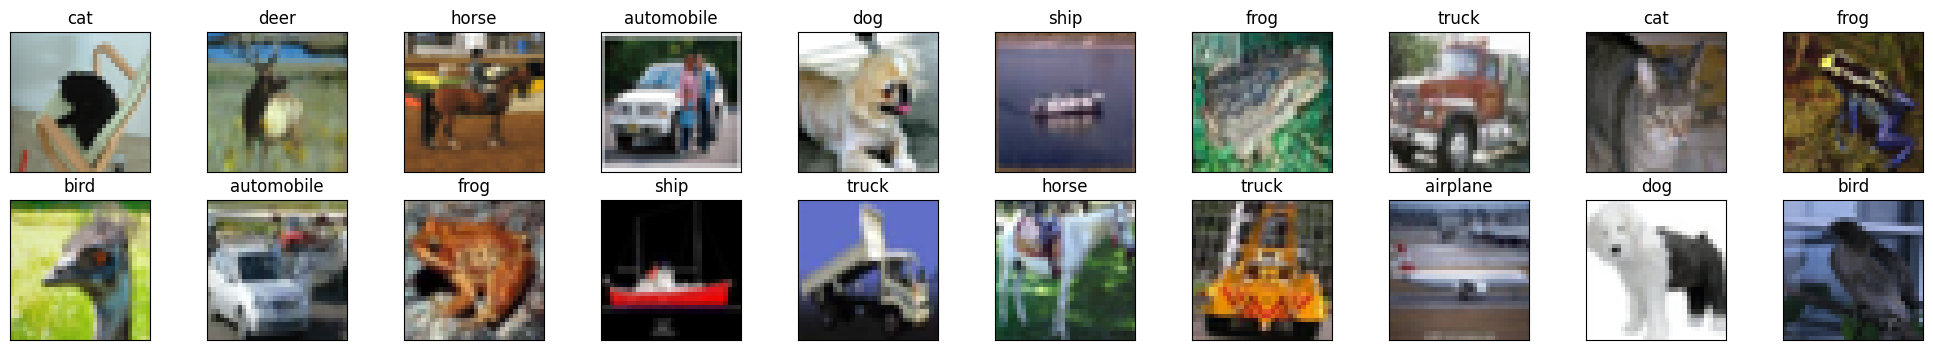

In [10]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

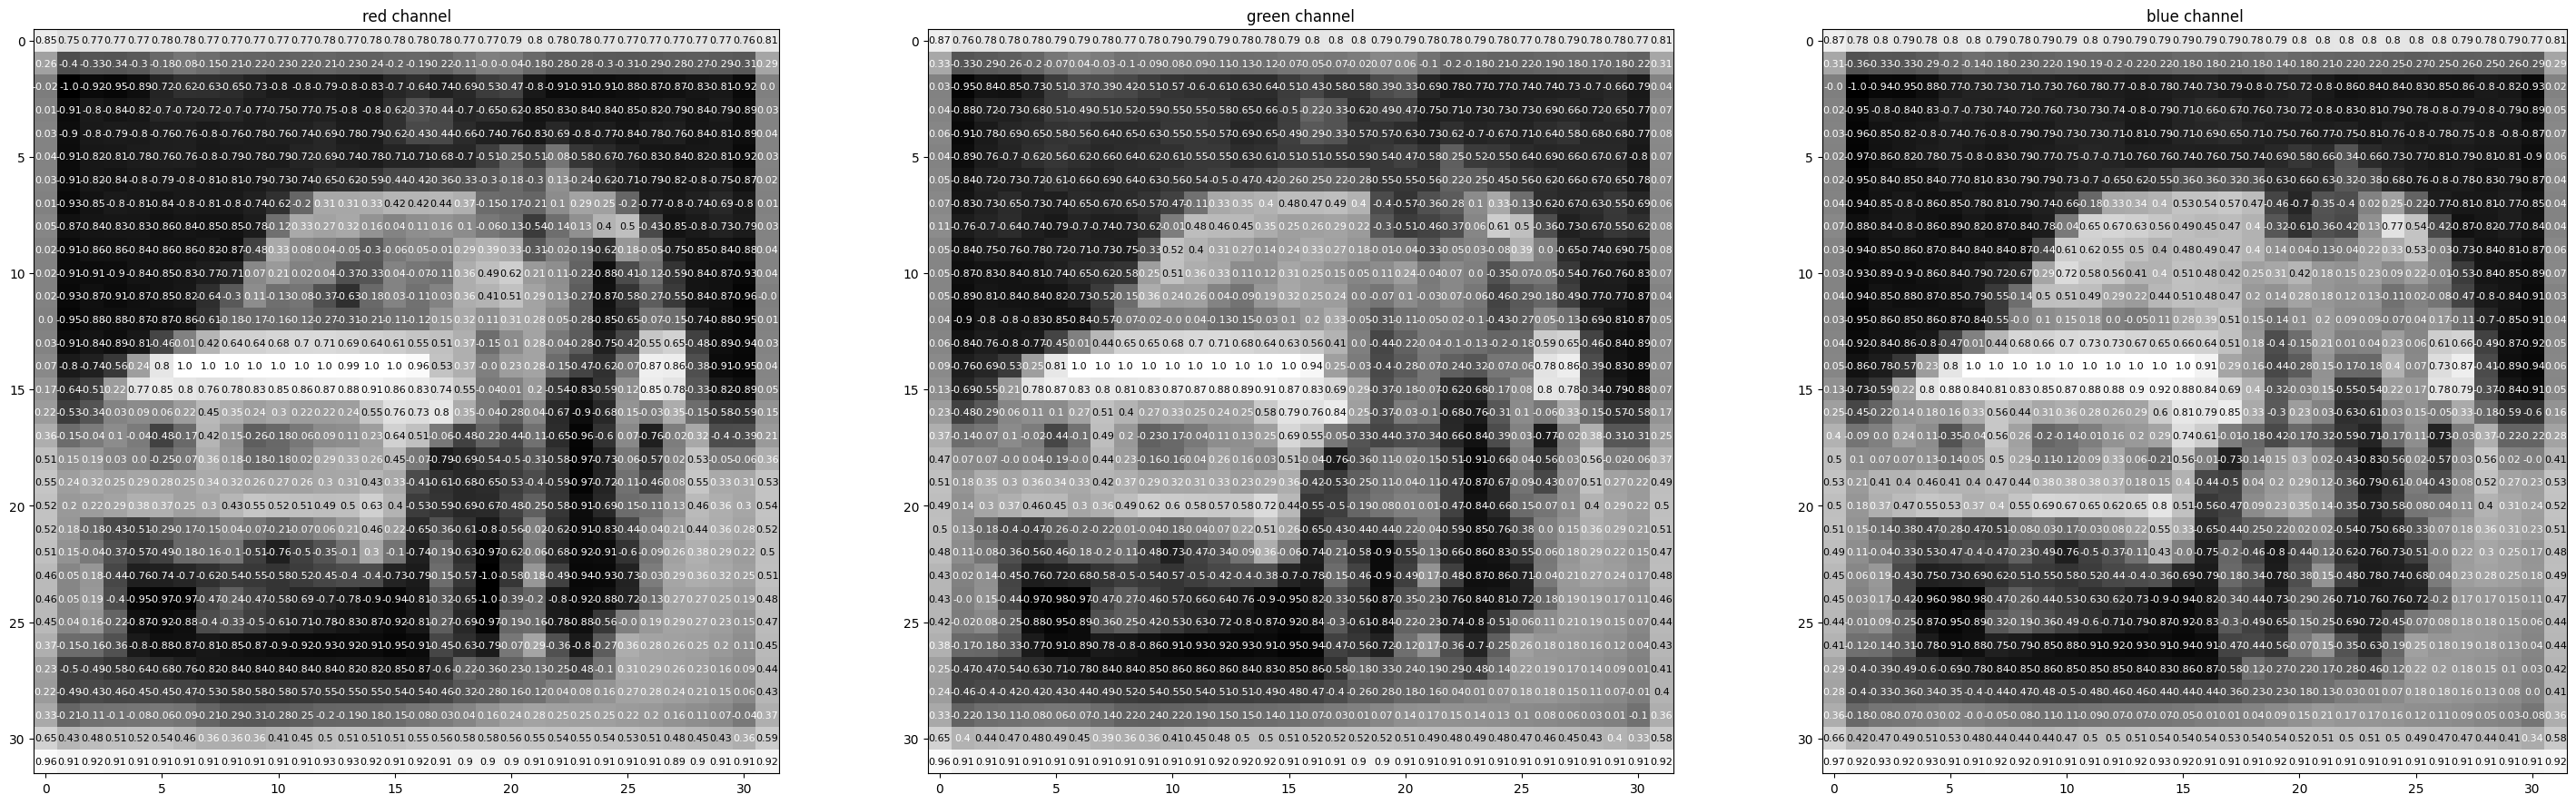

In [11]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Convolution Network 


<img src="https://drive.google.com/uc?export=download&id=135IBuqU3OHX70cenYP9ssfJby5FHj8Ky"   />

## Problem 1: 다음 구조를 갖는 convolution network을 만드세요

- 3개의 convolution layer
  - `conv1`: 
    - filter 수 16개
    - filter 크기: 3x3
    - padding = 1
    - stride = 1
  
  - `conv2`:
    - filter 수 32개
    - filter 크기: 3x3
    - padding = 1
    - stride = 1
  
  - `conv3`:
    - filter 수 64개
    - filter 크기: 3x3
    - padding = 1
    - stride = 1

- Maxpool layer
    - filter 크기 2x2
    - stride 2
    - `conv1`, `conv2`, `conv3` 이후에 각각 적용
    
- 2개의 FCN layer
    - `dropout` 적용 p=0.25 (최종 layer에 적용하나요?)
    - `fc1`
        - output neuron의 수: 500
    - `fc2`
        - 네트워크의 최종 output layer이며 Linear layer로 구성 (즉, softmax는 loss 함수에서 적용할 것)
        
        
아래 비어있는 부분을 완성하세요.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutional layer (sees 3x32x32 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, stride= 1, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, stride= 1,padding=1)
        # convolutional layer (sees 32x8x8 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, stride= 1, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, stride= 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(1024, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        # flatten image input
        x = x.reshape(-1, 1024)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = self.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = ConvNet()

# move tensors to GPU if CUDA is available
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): ReLU(inplace=True)
)

## Problem 2

본 classification 문제를 위해서 적절한 cost함수와 optimizer를 선언하세요


In [13]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer

optimizer = optim.Adam(model.parameters(), lr=0.003)

---
## Problem 3: Train and validation

- Training을 하고 각 epoch별로 validation을 수행하세요
    - 아래 epoch 별로 training loss, training accuracy, validation loss, validation accuracy를 저장하세요
    - `loss`가 최소인 model의 `state_dict`를 `model_cifar.pt`라는 파일명으로 저장하세요


In [14]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)

for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model.train()
    for data, labels in train_loader:
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()   #loss.detach().cpu().item()
        
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model.eval()
        for data, labels in valid_loader:
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()

            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    # calculate average losses
    valid_loss[e] /= len(valid_loader)
    valid_acc[e] /= len(valid_loader)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss[e]

Epoch: 0 	Training Loss: 1.519134 	Validation Loss: 1.275688
Epoch: 0 	Training accuracy: 0.441600 	Validation accuracy: 0.543292
Validation loss decreased (inf --> 1.275688).  Saving model ...
Epoch: 1 	Training Loss: 1.198501 	Validation Loss: 1.130187
Epoch: 1 	Training accuracy: 0.570150 	Validation accuracy: 0.604299
Validation loss decreased (1.275688 --> 1.130187).  Saving model ...
Epoch: 2 	Training Loss: 1.085025 	Validation Loss: 1.003410
Epoch: 2 	Training accuracy: 0.614425 	Validation accuracy: 0.646994
Validation loss decreased (1.130187 --> 1.003410).  Saving model ...
Epoch: 3 	Training Loss: 1.007137 	Validation Loss: 0.973027
Epoch: 3 	Training accuracy: 0.640225 	Validation accuracy: 0.654359
Validation loss decreased (1.003410 --> 0.973027).  Saving model ...
Epoch: 4 	Training Loss: 0.953944 	Validation Loss: 0.913774
Epoch: 4 	Training accuracy: 0.662425 	Validation accuracy: 0.680932
Validation loss decreased (0.973027 --> 0.913774).  Saving model ...
Epoch: 5 	

###  Load the Model with the Lowest Validation Loss

In [15]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

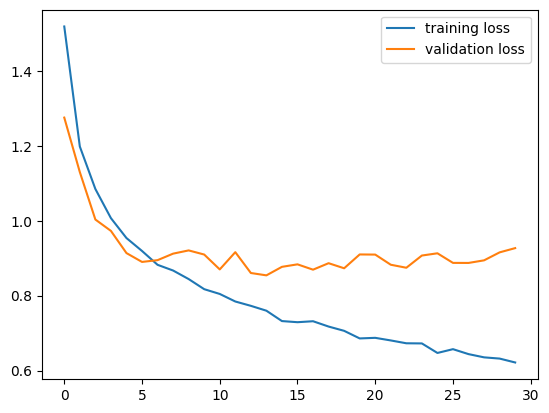

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label = 'training loss')
plt.plot(valid_loss, label = 'validation loss')
plt.legend()

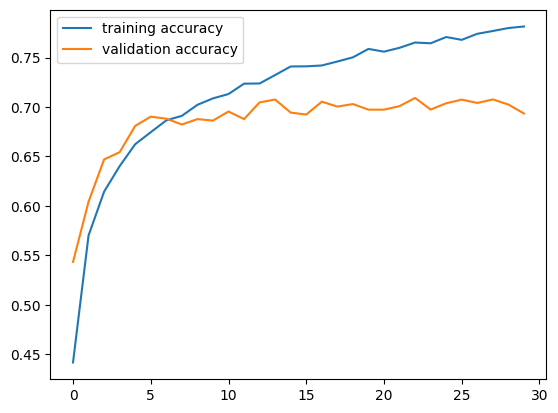

In [18]:
plt.plot(train_acc, label = 'training accuracy')
plt.plot(valid_acc, label = 'validation accuracy')
plt.legend()

---
## Problem 4


이제 Testset에 model을 적용하여 성능을 검증하세요.
최종 결과는 loss와 accuracy를 출력하세요.

제공한 기본 convolution network은 testset accuracy는 70% 전후반으로 나옵니다. 
- 구조를 변경하면서 최대 성능이 나오도록 해보세요. (숙제는 아니지만, 프로젝트는 이와 매우 흡사합니다)


In [19]:
# track test loss
test_loss = 0.0
test_acc = 0.0

class_correct = torch.zeros(10)
class_total = torch.zeros(10)

model.eval()
# iterate over test data
for data, labels in test_loader:
    # move tensors to GPU if CUDA is available
    data, labels = data.to(device), labels.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    logits = model(data)
    # calculate the batch loss
    loss = criterion(logits, labels)
    # update test loss 
    test_loss += loss.item()
    
    ps = F.softmax(logits, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.reshape(top_class.shape)
    test_acc += torch.mean(equals.type(torch.float)).detach().cpu()
    
    for i in range(len(data)):
        label = labels[i]
        class_correct[label] += equals[i].item()
        class_total[label] += 1
    

# average test loss
test_loss = test_loss/len(test_loader)
test_acc = test_acc/len(test_loader)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: {:.6f}\n'.format(test_acc))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            torch.sum(class_correct[i]), torch.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

Test Loss: 0.855729

Test Accuracy: 0.703623

Test Accuracy of airplane: 76% (764/1000)
Test Accuracy of automobile: 81% (813/1000)
Test Accuracy of  bird: 59% (593/1000)
Test Accuracy of   cat: 56% (563/1000)
Test Accuracy of  deer: 67% (676/1000)
Test Accuracy of   dog: 53% (537/1000)
Test Accuracy of  frog: 77% (775/1000)
Test Accuracy of horse: 71% (717/1000)
Test Accuracy of  ship: 79% (795/1000)
Test Accuracy of truck: 80% (804/1000)


### Visualize Sample Test Results

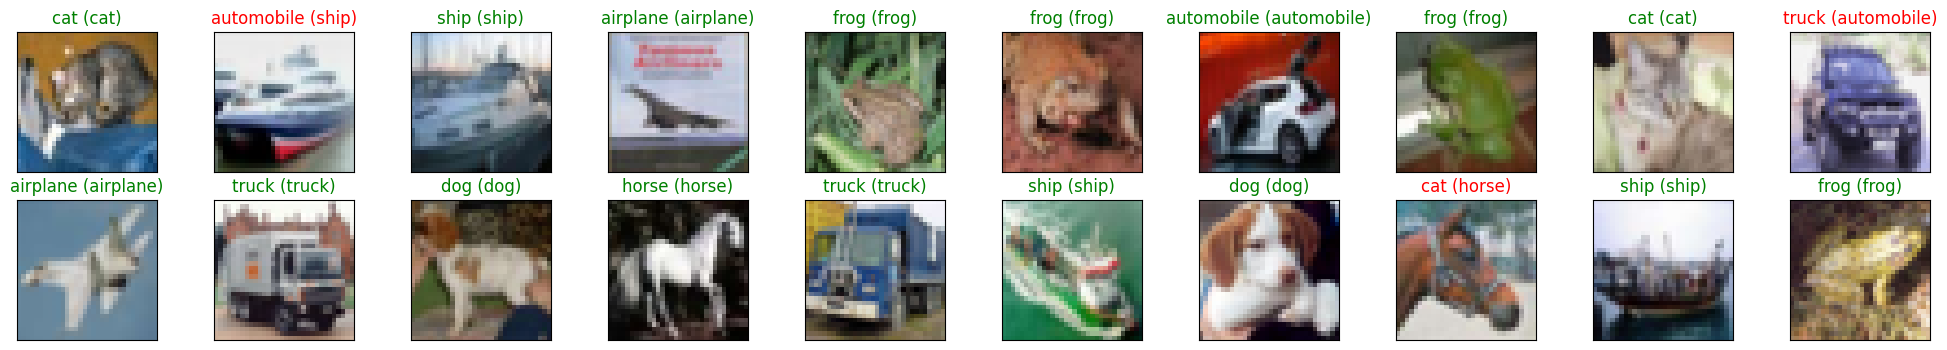

In [21]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))